In [1]:
import numpy             as np
import matplotlib.pyplot as plt

import h5py

import hylife.utilitis_FEEC.spline_space as spl
import hylife.utilitis_FEEC.bsplines as bsp
import hylife.utilitis_FEEC.basics.mass_matrices_3d as mass
import hylife.dispersion_relations.dispersion_relations as disp

import hylife.geometry.mappings_analytical as mapping

# 2. Results (old)

In [ ]:
# parameters and dispersion relation

k          = 0.75                        # wavenumber
g_sqrt     = 2*np.pi/k                   # Jacobi determinant
nuh        = 0.05                        # ration hot/cold ion number densities
rhoeq_phys = 1.                          # bulk mass density
nh0_phys   = rhoeq_phys*nuh              # hot ion number density on physical domain
nh0        = nh0_phys*g_sqrt             # hot ion number density on logical domain 
vth        = 1.                          # thermal velocity of hot ions
v0         = 2.5                         # mean velocity of hot ions

Ah         = 1.
Zh         = 1.
AMHD       = 1.

Eh_eq = nh0/2*(v0**2 + 3*vth**2/2)

w, counter = disp.solveDispersionFullOrbit(k, +1, +1, 1., vth, v0, nuh, Ah, Zh, AMHD, 1. + 0j, 1e-10, max_it=100)

wr = np.real(w)
wi = np.imag(w)

## 2. 1 $\delta f$
## 2. 1. 1 x - direction (pseudo-random, $N_\mathrm{p}=10^5, N_\mathrm{el}=20, \Delta t=0.04, a=10^{-4}$)

Text(0,0.5,'$|\\epsilon-\\epsilon_0|/\\epsilon_0}$')

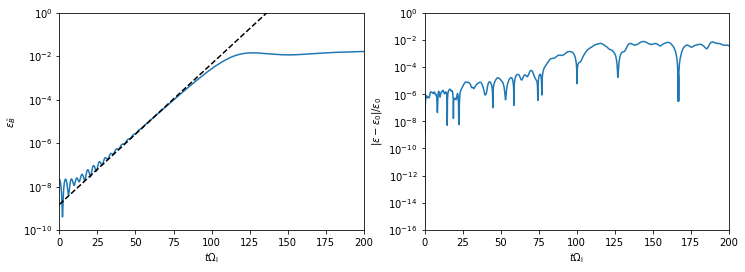

In [27]:
data = np.loadtxt('results/STRUPHY_Nel=20_p=3_L=2pidk_dt=0.04_Np=1e5_vth=1.0_v0=2.5_nuh=0.05_k=0.75_amp=1e-4_CV=on_x.txt')

en_U   = data[:, 0]
en_B   = data[:, 1]
en_H   = data[:, 2]
tn     = data[:, 3]
en_tot = en_U + en_B + en_H + Eh_eq


fig = plt.figure()
fig.set_figwidth(12)


plt.subplot(1, 2, 1)
plt.semilogy(tn, en_B)
plt.ylim((1e-10, 1e0))
plt.xlim((tn[0], tn[-1]))
plt.semilogy(tn, 1.5e-9*np.exp(2*tn*wi), 'k--')
plt.xlabel('$t\Omega_\mathrm{i}$')
plt.ylabel(r'$\epsilon_\tilde{B}$')

plt.subplot(1, 2, 2)
plt.semilogy(tn, np.abs(en_tot[0] - en_tot)/en_tot[0])
plt.ylim((1e-16, 1e0))
plt.xlim((tn[0], tn[-1]))
plt.xlabel('$t\Omega_\mathrm{i}$')
plt.ylabel(r'$|\epsilon-\epsilon_0|/\epsilon_0}$')

## 2. 1. 2 x - direction (sobol, $N_\mathrm{p}=10^5, N_\mathrm{el}=20, \Delta t=0.04, a=10^{-4}$)

Text(0,0.5,'$|\\epsilon-\\epsilon_0|/\\epsilon_0}$')

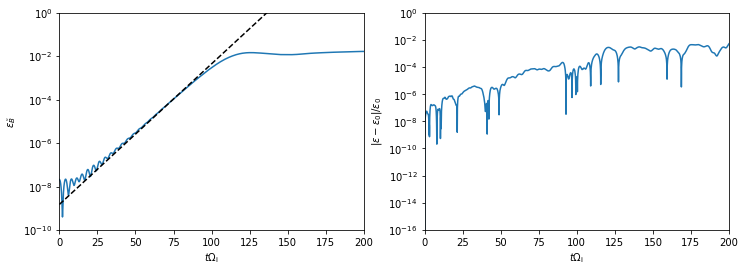

In [28]:
data = np.loadtxt('results/STRUPHY_Nel=20_p=3_L=2pidk_dt=0.04_Np=1e5_vth=1.0_v0=2.5_nuh=0.05_k=0.75_amp=1e-4_CV=on_x_sobol_ref.txt')

en_U   = data[:, 0]
en_B   = data[:, 1]
en_H   = data[:, 2]
tn     = data[:, 3]
en_tot = en_U + en_B + en_H + Eh_eq


fig = plt.figure()
fig.set_figwidth(12)


plt.subplot(1, 2, 1)
plt.semilogy(tn, en_B)
plt.ylim((1e-10, 1e0))
plt.xlim((tn[0], tn[-1]))
plt.semilogy(tn, 1.5e-9*np.exp(2*tn*wi), 'k--')
plt.xlabel('$t\Omega_\mathrm{i}$')
plt.ylabel(r'$\epsilon_\tilde{B}$')

plt.subplot(1, 2, 2)
plt.semilogy(tn, np.abs(en_tot[0] - en_tot)/en_tot[0])
plt.ylim((1e-16, 1e0))
plt.xlim((tn[0], tn[-1]))
plt.xlabel('$t\Omega_\mathrm{i}$')
plt.ylabel(r'$|\epsilon-\epsilon_0|/\epsilon_0}$')

## 2. 1. 3 y - direction (pseudo-random, $N_\mathrm{p}=10^5, N_\mathrm{el}=20, \Delta t=0.04, a=10^{-4}$)

Text(0,0.5,'$|\\epsilon-\\epsilon_0|/\\epsilon_0}$')

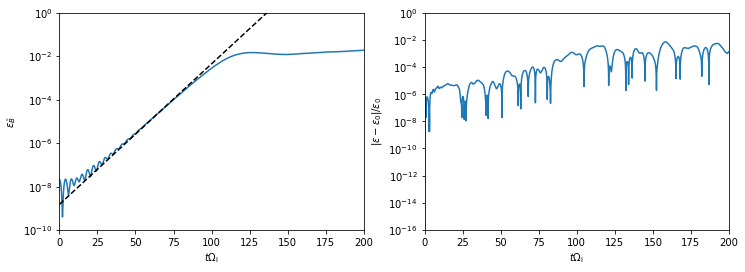

In [29]:
data = np.loadtxt('results/STRUPHY_Nel=20_p=3_L=2pidk_dt=0.04_Np=1e5_vth=1.0_v0=2.5_nuh=0.05_k=0.75_amp=1e-4_CV=on_y.txt')

en_U   = data[:, 0]
en_B   = data[:, 1]
en_H   = data[:, 2]
tn     = data[:, 3]
en_tot = en_U + en_B + en_H + Eh_eq


fig = plt.figure()
fig.set_figwidth(12)


plt.subplot(1, 2, 1)
plt.semilogy(tn, en_B)
plt.ylim((1e-10, 1e0))
plt.xlim((tn[0], tn[-1]))
plt.semilogy(tn, 1.5e-9*np.exp(2*tn*wi), 'k--')
plt.xlabel('$t\Omega_\mathrm{i}$')
plt.ylabel(r'$\epsilon_\tilde{B}$')

plt.subplot(1, 2, 2)
plt.semilogy(tn, np.abs(en_tot[0] - en_tot)/en_tot[0])
plt.ylim((1e-16, 1e0))
plt.xlim((tn[0], tn[-1]))
plt.xlabel('$t\Omega_\mathrm{i}$')
plt.ylabel(r'$|\epsilon-\epsilon_0|/\epsilon_0}$')

## 2. 1. 4 z - direction (pseudo-random, $N_\mathrm{p}=10^5, N_\mathrm{el}=20, \Delta t=0.04, a=10^{-4}$)

Text(0,0.5,'$|\\epsilon-\\epsilon_0|/\\epsilon_0}$')

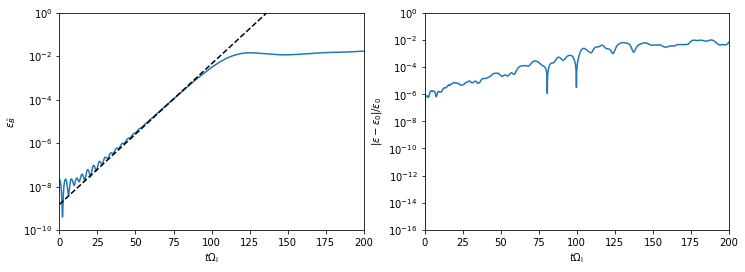

In [30]:
data = np.loadtxt('results/STRUPHY_Nel=20_p=3_L=2pidk_dt=0.04_Np=1e5_vth=1.0_v0=2.5_nuh=0.05_k=0.75_amp=1e-4_CV=on_z.txt')

en_U   = data[:, 0]
en_B   = data[:, 1]
en_H   = data[:, 2]
tn     = data[:, 3]
en_tot = en_U + en_B + en_H + Eh_eq


fig = plt.figure()
fig.set_figwidth(12)


plt.subplot(1, 2, 1)
plt.semilogy(tn, en_B)
plt.ylim((1e-10, 1e0))
plt.xlim((tn[0], tn[-1]))
plt.semilogy(tn, 1.5e-9*np.exp(2*tn*wi), 'k--')
plt.xlabel('$t\Omega_\mathrm{i}$')
plt.ylabel(r'$\epsilon_\tilde{B}$')

plt.subplot(1, 2, 2)
plt.semilogy(tn, np.abs(en_tot[0] - en_tot)/en_tot[0])
plt.ylim((1e-16, 1e0))
plt.xlim((tn[0], tn[-1]))
plt.xlabel('$t\Omega_\mathrm{i}$')
plt.ylabel(r'$|\epsilon-\epsilon_0|/\epsilon_0}$')

## 2. 1. 5 z - direction (sobol antithetic64 skip=1000, $N_\mathrm{p}=10^5, N_\mathrm{el}=16, \Delta t=0.06, a=10^{-3}$)

Text(0,0.5,'$|\\epsilon-\\epsilon_0|/\\epsilon_0}$')

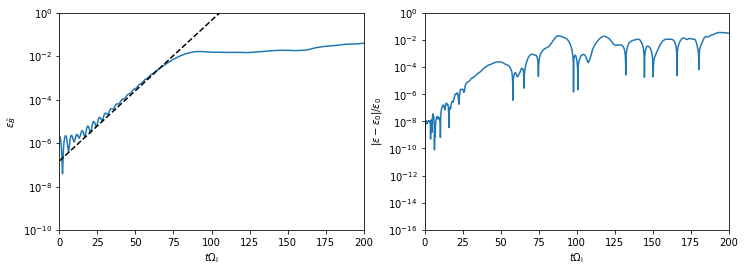

In [15]:
data = np.loadtxt('results/STRUPHY_Nel=16_p=3_L=2pidk_dt=0.06_Np=100032_vth=1.0_v0=2.5_nuh=0.05_k=0.75_amp=1e-3_CV=on_x_sobol_a64.txt')

en_U   = data[:, 0]
en_B   = data[:, 1]
en_p   = data[:, 2]
en_H   = data[:, 3]
tn     = data[:, 4]
en_tot = en_U + en_B + en_H + Eh_eq


fig = plt.figure()
fig.set_figwidth(12)


plt.subplot(1, 2, 1)
plt.semilogy(tn, en_B)
plt.ylim((1e-10, 1e0))
plt.xlim((tn[0], tn[-1]))
plt.semilogy(tn, 1.5e-7*np.exp(2*tn*wi), 'k--')
plt.xlabel('$t\Omega_\mathrm{i}$')
plt.ylabel(r'$\epsilon_\tilde{B}$')

plt.subplot(1, 2, 2)
plt.semilogy(tn, np.abs(en_tot[0] - en_tot)/en_tot[0])
plt.ylim((1e-16, 1e0))
plt.xlim((tn[0], tn[-1]))
plt.xlabel('$t\Omega_\mathrm{i}$')
plt.ylabel(r'$|\epsilon-\epsilon_0|/\epsilon_0}$')

## 2. 1. 6 xy - direction (pseudo-random, $N_\mathrm{p}=4\cdot10^5, N_\mathrm{el}=[20, 20], \Delta t=0.04, a=10^{-4}$)

Text(0,0.5,'$|\\epsilon-\\epsilon_0|/\\epsilon_0}$')

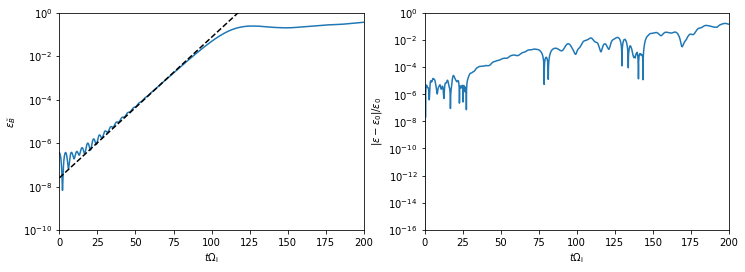

In [34]:
data = np.loadtxt('results/STRUPHY_Nel=20_p=3_L=2pidk_dt=0.04_Np=4e5_vth=1.0_v0=2.5_nuh=0.05_k=0.75_amp=1e-4_CV=on_xy.txt')

en_U   = data[:, 0]
en_B   = data[:, 1]
en_H   = data[:, 2]
tn     = data[:, 3]
en_tot = en_U + en_B + en_H + Eh_eq


fig = plt.figure()
fig.set_figwidth(12)


plt.subplot(1, 2, 1)
plt.semilogy(tn, en_B)
plt.ylim((1e-10, 1e0))
plt.xlim((tn[0], tn[-1]))
plt.semilogy(tn, 2.5e-8*np.exp(2*tn*wi), 'k--')
plt.xlabel('$t\Omega_\mathrm{i}$')
plt.ylabel(r'$\epsilon_\tilde{B}$')

plt.subplot(1, 2, 2)
plt.semilogy(tn, np.abs(en_tot[0] - en_tot)/en_tot[0])
plt.ylim((1e-16, 1e0))
plt.xlim((tn[0], tn[-1]))
plt.xlabel('$t\Omega_\mathrm{i}$')
plt.ylabel(r'$|\epsilon-\epsilon_0|/\epsilon_0}$')

## 2. 2 full-$f$

## 2. 2. 1 z - direction (pseudo-random, $N_\mathrm{p}=5\cdot10^6, N_\mathrm{el}=20, \Delta t=0.04, a=10^{-5}$)

Text(0,0.5,'$|\\epsilon-\\epsilon_0|/\\epsilon_0}$')

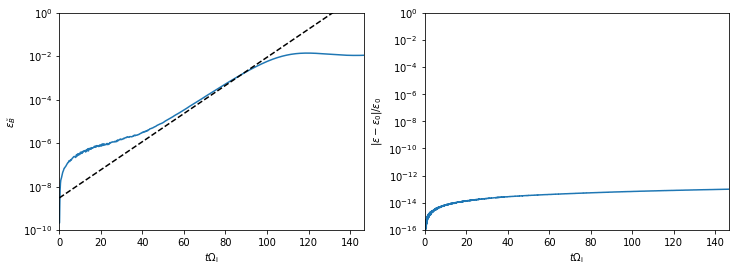

In [39]:
data = np.loadtxt('results/STRUPHY_Nel=20_p=3_L=2pidk_dt=0.04_Np=5e6_vth=1.0_v0=2.5_nuh=0.05_k=0.75_amp=1e-5_CV=off_z.txt')

en_U   = data[:, 0]
en_B   = data[:, 1]
en_H   = data[:, 2]
tn     = data[:, 3]
en_tot = en_U + en_B + en_H + Eh_eq


fig = plt.figure()
fig.set_figwidth(12)


plt.subplot(1, 2, 1)
plt.semilogy(tn, en_B)
plt.ylim((1e-10, 1e0))
plt.xlim((tn[0], tn[-1]))
plt.semilogy(tn, 3e-9*np.exp(2*tn*wi), 'k--')
plt.xlabel('$t\Omega_\mathrm{i}$')
plt.ylabel(r'$\epsilon_\tilde{B}$')

plt.subplot(1, 2, 2)
plt.semilogy(tn, np.abs(en_tot[0] - en_tot)/en_tot[0])
plt.ylim((1e-16, 1e0))
plt.xlim((tn[0], tn[-1]))
plt.xlabel('$t\Omega_\mathrm{i}$')
plt.ylabel(r'$|\epsilon-\epsilon_0|/\epsilon_0}$')

## 2. 2. 2 z - direction (sobol, $N_\mathrm{p}=5\cdot10^6, N_\mathrm{el}=20, \Delta t=0.04, a=10^{-5}$)

Text(0,0.5,'$|\\epsilon-\\epsilon_0|/\\epsilon_0}$')

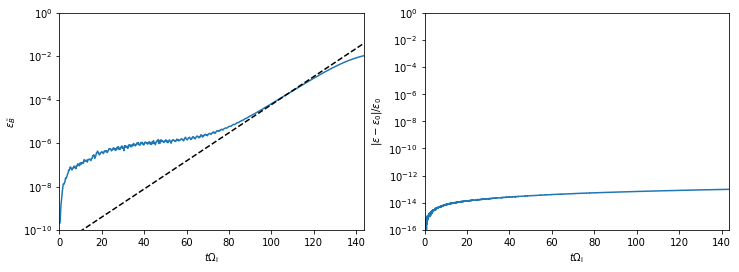

In [43]:
data = np.loadtxt('results/STRUPHY_Nel=20_p=3_L=2pidk_dt=0.04_Np=5e6_vth=1.0_v0=2.5_nuh=0.05_k=0.75_amp=1e-5_CV=off_z_sobol.txt')

en_U   = data[:, 0]
en_B   = data[:, 1]
en_H   = data[:, 2]
tn     = data[:, 3]
en_tot = en_U + en_B + en_H + Eh_eq


fig = plt.figure()
fig.set_figwidth(12)


plt.subplot(1, 2, 1)
plt.semilogy(tn, en_B)
plt.ylim((1e-10, 1e0))
plt.xlim((tn[0], tn[-1]))
plt.semilogy(tn, 2e-11*np.exp(2*tn*wi), 'k--')
plt.xlabel('$t\Omega_\mathrm{i}$')
plt.ylabel(r'$\epsilon_\tilde{B}$')

plt.subplot(1, 2, 2)
plt.semilogy(tn, np.abs(en_tot[0] - en_tot)/en_tot[0])
plt.ylim((1e-16, 1e0))
plt.xlim((tn[0], tn[-1]))
plt.xlabel('$t\Omega_\mathrm{i}$')
plt.ylabel(r'$|\epsilon-\epsilon_0|/\epsilon_0}$')

## 2. 2. 3 x - direction (pseudo-random, $N_\mathrm{p}=1\cdot10^7, N_\mathrm{el}=16, \Delta t=0.08, a=10^{-6}$)

Text(0,0.5,'$|\\epsilon-\\epsilon_0|/\\epsilon_0}$')

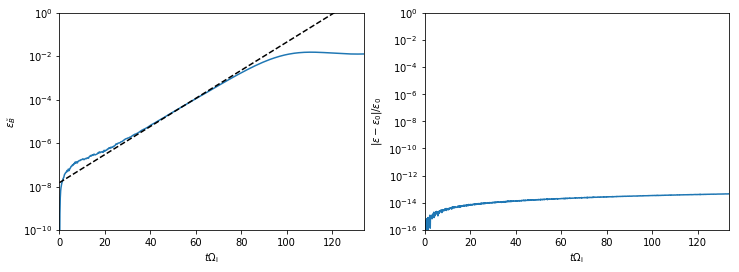

In [47]:
data = np.loadtxt('results/STRUPHY_Nel=16_p=3_L=2pidk_dt=0.08_Np=1e7_vth=1.0_v0=2.5_nuh=0.05_k=0.75_amp=1e-6_CV=off_x.txt')

en_U   = data[:, 0]
en_B   = data[:, 1]
en_H   = data[:, 2]
tn     = data[:, 3]
en_tot = en_U + en_B + en_H + Eh_eq


fig = plt.figure()
fig.set_figwidth(12)


plt.subplot(1, 2, 1)
plt.semilogy(tn, en_B)
plt.ylim((1e-10, 1e0))
plt.xlim((tn[0], tn[-1]))
plt.semilogy(tn, 1.5e-8*np.exp(2*tn*wi), 'k--')
plt.xlabel('$t\Omega_\mathrm{i}$')
plt.ylabel(r'$\epsilon_\tilde{B}$')

plt.subplot(1, 2, 2)
plt.semilogy(tn, np.abs(en_tot[0] - en_tot)/en_tot[0])
plt.ylim((1e-16, 1e0))
plt.xlim((tn[0], tn[-1]))
plt.xlabel('$t\Omega_\mathrm{i}$')
plt.ylabel(r'$|\epsilon-\epsilon_0|/\epsilon_0}$')

## 2. 2. 4 x - direction (sobol antithetic skip=1000, $N_\mathrm{p}=1\cdot10^7, N_\mathrm{el}=16, \Delta t=0.08, a=10^{-6}$)

Text(0,0.5,'$|\\epsilon-\\epsilon_0|/\\epsilon_0}$')

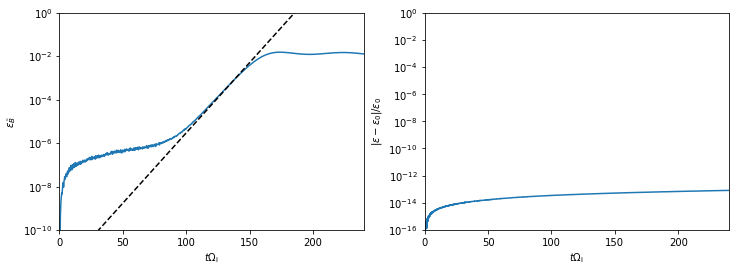

In [51]:
data = np.loadtxt('results/STRUPHY_Nel=16_p=3_L=2pidk_dt=0.08_Np=1e7_vth=1.0_v0=2.5_nuh=0.05_k=0.75_amp=1e-6_CV=off_x_sobola1000.txt')

en_U   = data[:, 0]
en_B   = data[:, 1]
en_H   = data[:, 2]
tn     = data[:, 3]
en_tot = en_U + en_B + en_H + Eh_eq


fig = plt.figure()
fig.set_figwidth(12)


plt.subplot(1, 2, 1)
plt.semilogy(tn, en_B)
plt.ylim((1e-10, 1e0))
plt.xlim((tn[0], tn[-1]))
plt.semilogy(tn, 1e-12*np.exp(2*tn*wi), 'k--')
plt.xlabel('$t\Omega_\mathrm{i}$')
plt.ylabel(r'$\epsilon_\tilde{B}$')

plt.subplot(1, 2, 2)
plt.semilogy(tn, np.abs(en_tot[0] - en_tot)/en_tot[0])
plt.ylim((1e-16, 1e0))
plt.xlim((tn[0], tn[-1]))
plt.xlabel('$t\Omega_\mathrm{i}$')
plt.ylabel(r'$|\epsilon-\epsilon_0|/\epsilon_0}$')

## 2. 2. 5 x - direction (sobol antithetic64 skip=1000, $N_\mathrm{p}=8192000, N_\mathrm{el}=16, \Delta t=0.08, a=10^{-4}$)

Text(0,0.5,'$|\\epsilon-\\epsilon_0|/\\epsilon_0}$')

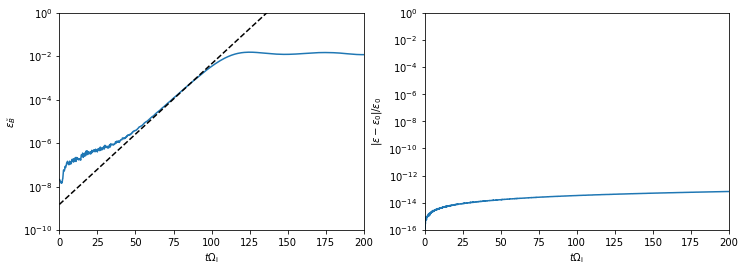

In [9]:
data = np.loadtxt('results/STRUPHY_Nel=16_p=3_L=2pidk_dt=0.08_Np=8192000_vth=1.0_v0=2.5_nuh=0.05_k=0.75_amp=1e-4_CV=off_x_sobola.txt')

en_U   = data[:, 0]
en_B   = data[:, 1]
en_H   = data[:, 2]
tn     = data[:, 3]
en_tot = en_U + en_B + en_H + Eh_eq


fig = plt.figure()
fig.set_figwidth(12)


plt.subplot(1, 2, 1)
plt.semilogy(tn, en_B)
plt.ylim((1e-10, 1e0))
plt.xlim((tn[0], tn[-1]))
plt.semilogy(tn, 1.5e-9*np.exp(2*tn*wi), 'k--')
plt.xlabel('$t\Omega_\mathrm{i}$')
plt.ylabel(r'$\epsilon_\tilde{B}$')

plt.subplot(1, 2, 2)
plt.semilogy(tn, np.abs(en_tot[0] - en_tot)/en_tot[0])
plt.ylim((1e-16, 1e0))
plt.xlim((tn[0], tn[-1]))
plt.xlabel('$t\Omega_\mathrm{i}$')
plt.ylabel(r'$|\epsilon-\epsilon_0|/\epsilon_0}$')

## 2. 2. 6 x - direction (sobol antithetic64 skip=1000, $N_\mathrm{p}=9932800, N_\mathrm{el}=16, \Delta t=0.06, a=10^{-4}$)

Text(0,0.5,'$|\\epsilon-\\epsilon_0|/\\epsilon_0}$')

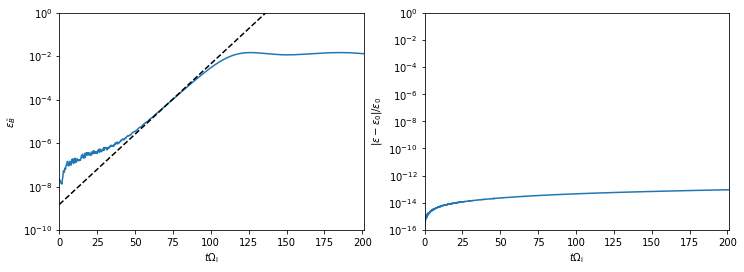

In [4]:
data = np.loadtxt('results/STRUPHY_Nel=16_p=3_L=2pidk_dt=0.06_Np=9932800_vth=1.0_v0=2.5_nuh=0.05_k=0.75_amp=1e-4_CV=off_x_sobol_a64.txt')

en_U   = data[:, 0]
en_B   = data[:, 1]
en_H   = data[:, 2]
tn     = data[:, 3]
en_tot = en_U + en_B + en_H + Eh_eq


fig = plt.figure()
fig.set_figwidth(12)


plt.subplot(1, 2, 1)
plt.semilogy(tn, en_B)
plt.ylim((1e-10, 1e0))
plt.xlim((tn[0], tn[-1]))
plt.semilogy(tn, 1.5e-9*np.exp(2*tn*wi), 'k--')
plt.xlabel('$t\Omega_\mathrm{i}$')
plt.ylabel(r'$\epsilon_\tilde{B}$')

plt.subplot(1, 2, 2)
plt.semilogy(tn, np.abs(en_tot[0] - en_tot)/en_tot[0])
plt.ylim((1e-16, 1e0))
plt.xlim((tn[0], tn[-1]))
plt.xlabel('$t\Omega_\mathrm{i}$')
plt.ylabel(r'$|\epsilon-\epsilon_0|/\epsilon_0}$')

## 2. 2. 7 x - direction (sobol antithetic64 skip=1000, $N_\mathrm{p}=9932800, N_\mathrm{el}=16, \Delta t=0.06, a=10^{-3}$)

Text(0,0.5,'$|\\epsilon-\\epsilon_0|/\\epsilon_0}$')

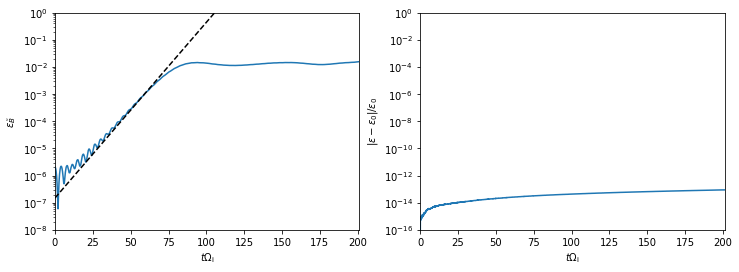

In [22]:
data = np.loadtxt('results/STRUPHY_Nel=16_p=3_L=2pidk_dt=0.06_Np=9932800_vth=1.0_v0=2.5_nuh=0.05_k=0.75_amp=1e-3_CV=off_x_sobol_a64.txt')

en_U   = data[:, 0]
en_B   = data[:, 1]
en_H   = data[:, 2]
tn     = data[:, 3]
en_tot = en_U + en_B + en_H + Eh_eq


fig = plt.figure()
fig.set_figwidth(12)


plt.subplot(1, 2, 1)
plt.semilogy(tn, en_B)
plt.ylim((1e-8, 1e0))
plt.xlim((tn[0], tn[-1]))
plt.semilogy(tn, 1.5e-7*np.exp(2*tn*wi), 'k--')
plt.xlabel('$t\Omega_\mathrm{i}$')
plt.ylabel(r'$\epsilon_\tilde{B}$')

plt.subplot(1, 2, 2)
plt.semilogy(tn, np.abs(en_tot[0] - en_tot)/en_tot[0])
plt.ylim((1e-16, 1e0))
plt.xlim((tn[0], tn[-1]))
plt.xlabel('$t\Omega_\mathrm{i}$')
plt.ylabel(r'$|\epsilon-\epsilon_0|/\epsilon_0}$')

## 2. 2. 8 x - direction (sobol antithetic64 skip=1000, $N_\mathrm{p}=8192000, N_\mathrm{el}=16, \Delta t=0.06, a=10^{-3}$)

Text(0,0.5,'$|\\epsilon-\\epsilon_0|/\\epsilon_0}$')

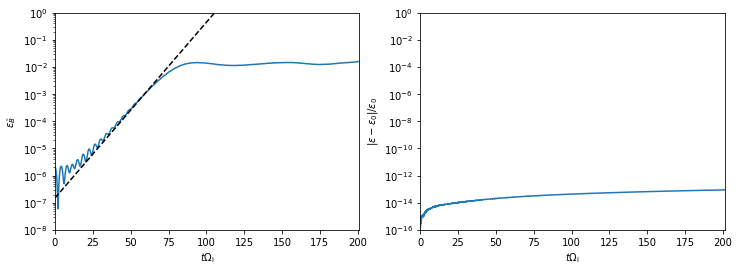

In [11]:
data = np.loadtxt('results/STRUPHY_Nel=16_p=3_L=2pidk_dt=0.06_Np=8192000_vth=1.0_v0=2.5_nuh=0.05_k=0.75_amp=1e-3_CV=off_x_sobol_a64.txt')

en_U   = data[:, 0]
en_B   = data[:, 1]
en_H   = data[:, 2]
tn     = data[:, 3]
en_tot = en_U + en_B + en_H + Eh_eq


fig = plt.figure()
fig.set_figwidth(12)


plt.subplot(1, 2, 1)
plt.semilogy(tn, en_B)
plt.ylim((1e-8, 1e0))
plt.xlim((tn[0], tn[-1]))
plt.semilogy(tn, 1.5e-7*np.exp(2*tn*wi), 'k--')
plt.xlabel('$t\Omega_\mathrm{i}$')
plt.ylabel(r'$\epsilon_\tilde{B}$')

plt.subplot(1, 2, 2)
plt.semilogy(tn, np.abs(en_tot[0] - en_tot)/en_tot[0])
plt.ylim((1e-16, 1e0))
plt.xlim((tn[0], tn[-1]))
plt.xlabel('$t\Omega_\mathrm{i}$')
plt.ylabel(r'$|\epsilon-\epsilon_0|/\epsilon_0}$')

## 2. 2. 9 x - direction (sobol antithetic64 skip=1000, $N_\mathrm{p}=4096000, N_\mathrm{el}=16, \Delta t=0.06, a=10^{-3}$)

Text(0,0.5,'$|\\epsilon-\\epsilon_0|/\\epsilon_0}$')

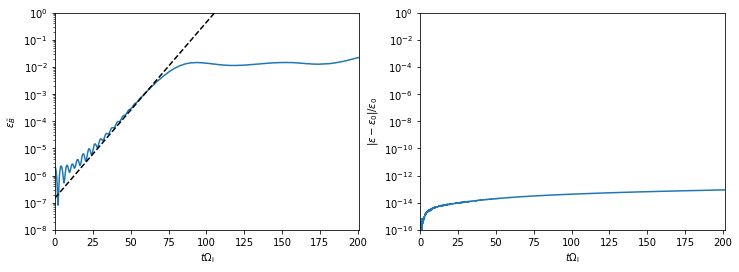

In [8]:
data = np.loadtxt('results/STRUPHY_Nel=16_p=3_L=2pidk_dt=0.06_Np=4096000_vth=1.0_v0=2.5_nuh=0.05_k=0.75_amp=1e-3_CV=off_x_sobol_a64.txt')

en_U   = data[:, 0]
en_B   = data[:, 1]
en_H   = data[:, 2]
tn     = data[:, 3]
en_tot = en_U + en_B + en_H + Eh_eq


fig = plt.figure()
fig.set_figwidth(12)


plt.subplot(1, 2, 1)
plt.semilogy(tn, en_B)
plt.ylim((1e-8, 1e0))
plt.xlim((tn[0], tn[-1]))
plt.semilogy(tn, 1.5e-7*np.exp(2*tn*wi), 'k--')
plt.xlabel('$t\Omega_\mathrm{i}$')
plt.ylabel(r'$\epsilon_\tilde{B}$')

plt.subplot(1, 2, 2)
plt.semilogy(tn, np.abs(en_tot[0] - en_tot)/en_tot[0])
plt.ylim((1e-16, 1e0))
plt.xlim((tn[0], tn[-1]))
plt.xlabel('$t\Omega_\mathrm{i}$')
plt.ylabel(r'$|\epsilon-\epsilon_0|/\epsilon_0}$')

## 2. 2. 10 xy - direction (pseudo-random, $N_\mathrm{p}=5\cdot10^6, N_\mathrm{el}=[20,20], \Delta t=0.1, a=10^{-6}$)

Text(0,0.5,'$|\\epsilon-\\epsilon_0|/\\epsilon_0}$')

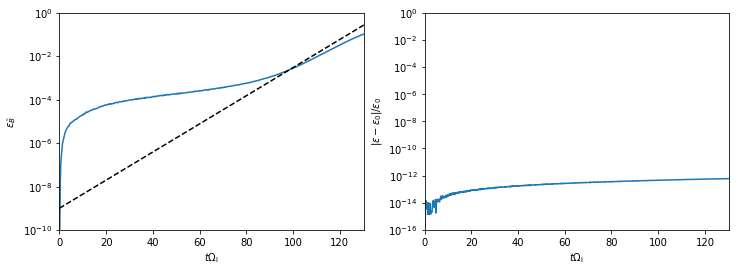

In [54]:
data = np.loadtxt('results/STRUPHY_Nel=20_p=3_L=2pidk_dt=0.1_Np=5e6_vth=1.0_v0=2.5_nuh=0.05_k=0.75_amp=1e-6_CV=off_xy.txt')

en_U   = data[:, 0]
en_B   = data[:, 1]
en_H   = data[:, 2]
tn     = data[:, 3]
en_tot = en_U + en_B + en_H + Eh_eq


fig = plt.figure()
fig.set_figwidth(12)


plt.subplot(1, 2, 1)
plt.semilogy(tn, en_B)
plt.ylim((1e-10, 1e0))
plt.xlim((tn[0], tn[-1]))
plt.semilogy(tn, 1e-9*np.exp(2*tn*wi), 'k--')
plt.xlabel('$t\Omega_\mathrm{i}$')
plt.ylabel(r'$\epsilon_\tilde{B}$')

plt.subplot(1, 2, 2)
plt.semilogy(tn, np.abs(en_tot[0] - en_tot)/en_tot[0])
plt.ylim((1e-16, 1e0))
plt.xlim((tn[0], tn[-1]))
plt.xlabel('$t\Omega_\mathrm{i}$')
plt.ylabel(r'$|\epsilon-\epsilon_0|/\epsilon_0}$')

## 2. 3 Pure MHD

## 2. 3. 1 1D $\mathbf{k}=k\mathbf{e}_x$ with $\mathbf{B}_0=B_{0x}\mathbf{e}_x+B_{0y}\mathbf{e}_y$

In [101]:
data = np.loadtxt('simulation_06042020_1/output.txt')

In [102]:
Nel  = [128, 4, 4]               # mesh generation on logical domain
bc   = [True, True, True]        # boundary conditions (True: periodic, False: else)
p    = [3, 2, 2]                 # spline degrees  
L    = [20., 1., 1.]             # box lengthes of physical domain
Ntot = Nel[0]*Nel[1]*Nel[2]
dt   = 0.05
Tend = 20.
Nt   = int(Tend/dt)

pr   = data[:, 0*Ntot:1*Ntot].reshape(Nt + 1, Nel[0], Nel[1], Nel[2])
uz   = data[:, 1*Ntot:2*Ntot].reshape(Nt + 1, Nel[0], Nel[1], Nel[2])
tn   = np.linspace(0., Tend, Nt + 1)


w = np.linspace(0, Nt, Nt + 1) - Nt/2
w = 2*np.pi/Tend*w

k = np.linspace(0, Nel[0], Nel[0] + 1) - Nel[0]/2
k = 2*np.pi/L[0]*k

pr_fft      = np.fft.fft2(np.c_[pr[:, :, 1, 1], pr[:, 0, 1, 1]])
W, K        = np.meshgrid(w, k, indexing='ij')
pr_fft      = np.fft.fftshift(pr_fft)
pr_fft_plot = np.abs(pr_fft)


uz_fft      = np.fft.fft2(np.c_[uz[:, :, 1, 1], uz[:, 0, 1, 1]])
W, K        = np.meshgrid(w, k, indexing='ij')
uz_fft      = np.fft.fftshift(uz_fft)
uz_fft_plot = np.abs(uz_fft)


vFast  = disp.omegaM(1., +1, [1., 1., 0.], 1., 1., 5/3)
vSlow  = disp.omegaM(1., -1, [1., 1., 0.], 1., 1., 5/3)
vShear = disp.omegaS(1., [1., 1., 0.], 1.)

Text(0,0.5,'w')

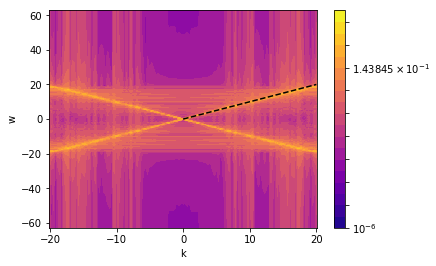

In [105]:
from matplotlib.colors import LogNorm

lvls = np.logspace(-6, 1, 20)
plt.contourf(K, W, uz_fft_plot/uz_fft_plot.max(), cmap = 'plasma', norm = LogNorm(), levels=lvls)

plt.plot(np.linspace(0, 20, 50), vShear*np.linspace(0, 20, 50), 'k--')
#plt.xlim((-10, 10))
#plt.ylim((-20, 20))

plt.colorbar()
plt.xlabel('k')
plt.ylabel('w')

Text(0,0.5,'w')

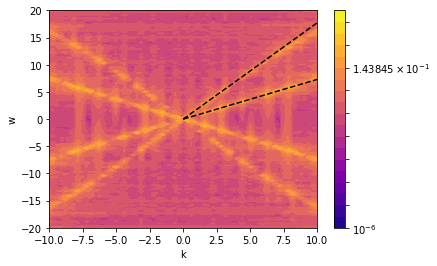

In [106]:
from matplotlib.colors import LogNorm

lvls = np.logspace(-6, 1, 20)
plt.contourf(K, W, pr_fft_plot/pr_fft_plot.max(), cmap = 'plasma', norm = LogNorm(), levels=lvls)

plt.plot(np.linspace(0, 10, 50), vFast*np.linspace(0, 10, 50), 'k--')
plt.plot(np.linspace(0, 10, 50), vSlow*np.linspace(0, 10, 50), 'k--')
plt.xlim((-10, 10))
plt.ylim((-20, 20))

plt.colorbar()
plt.xlabel('k')
plt.ylabel('w')

## 2. 3. 2 2D $\mathbf{k}=k_x\mathbf{e}_x+k_y\mathbf{e}_y$ with $\mathbf{B}_0=B_{0}\mathbf{e}_x$

In [107]:
data = np.loadtxt('simulation_06042020_3/output_simulation_06042020_3.txt')

In [170]:
Nel  = [64, 64, 4]               # mesh generation on logical domain
bc   = [True, True, True]        # boundary conditions (True: periodic, False: else)
p    = [3, 3, 2]                 # spline degrees  
L    = [18., 18., 1.]             # box lengthes of physical domain
Ntot = Nel[0]*Nel[1]*Nel[2]
dt   = 0.05
Tend = 20.
Nt   = int(Tend/dt)

el_b        = [np.linspace(0., 1., Nel + 1) for Nel in Nel]                      # element boundaries
delta       = [1/Nel for Nel in Nel]                                             # element sizes
T           = [bsp.make_knots(el_b, p, bc) for el_b, p, bc in zip(el_b, p, bc)]  # knot vectors (for N functions)

pr   = data[:, 0*Ntot:1*Ntot].reshape(Nt + 1, Nel[0], Nel[1], Nel[2])
uz   = data[:, 1*Ntot:2*Ntot].reshape(Nt + 1, Nel[0], Nel[1], Nel[2])
tn   = np.linspace(0., Tend, Nt + 1)


w = np.linspace(0, Nt, Nt + 1) - Nt/2
w = 2*np.pi/Tend*w

kx = np.linspace(0, Nel[0], Nel[0] + 1) - Nel[0]/2
kx = 2*np.pi/L[0]*kx

ky = np.linspace(0, Nel[1], Nel[1] + 1) - Nel[1]/2
ky = 2*np.pi/L[1]*ky


# evaluate pressure on element vertices
pr_eva = np.zeros((Nt + 1, Nel[0] + 1, Nel[1] + 1))

for i in range(Nt + 1):
    pr_0form = fem._0form(T, p, bc, pr[i])
    
    pr_eva[i] = pr_0form.evaluate([el_b[0], el_b[1], np.array([0.5])]).reshape(Nel[0] + 1, Nel[1] + 1)
    
# evaluate velocity on element vertices
uz_eva = np.zeros((Nt + 1, Nel[0] + 1, Nel[1] + 1))

for i in range(Nt + 1):
    u_1form = fem._1form(T, p, bc, [uz[i], uz[i], uz[i]])
    
    uz_eva[i] = u_1form.evaluate_3component([el_b[0], el_b[1], np.array([0.5])]).reshape(Nel[0] + 1, Nel[1] + 1)

In [171]:
# 3D fast Fourier transform
pr_fft      = np.fft.fftn(pr_eva)
W, KX, KY   = np.meshgrid(w, kx, ky, indexing='ij')
pr_fft      = np.fft.fftshift(pr_fft)
pr_fft_plot = np.abs(pr_fft)

uz_fft      = np.fft.fftn(uz_eva)
W, KX, KY   = np.meshgrid(w, kx, ky, indexing='ij')
uz_fft      = np.fft.fftshift(uz_fft)
uz_fft_plot = np.abs(uz_fft)

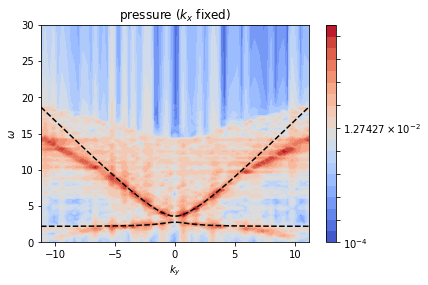

In [220]:
from matplotlib.colors import LogNorm

n_mode_x = 40

lvls = np.logspace(-4, 0, 20)
plt.contourf(KY[:, n_mode_x, :], W[:, n_mode_x, :], pr_fft_plot[:, n_mode_x, :]/pr_fft_plot[:, n_mode_x, :].max(), cmap = 'coolwarm', norm = LogNorm(), levels=lvls)

plt.ylim((0., 30.))
#plt.xlim((-5., 5.))

om_fast = disp.omegaM_xy(kx[n_mode_x], ky, +1, 1., 1., 1., 5/3)
om_slow = disp.omegaM_xy(kx[n_mode_x], ky, -1, 1., 1., 1., 5/3)

plt.plot(ky, om_fast, 'k--')
plt.plot(ky, om_slow, 'k--')

plt.xlabel('$k_y$')
plt.ylabel('$\omega$')
plt.title('pressure ($k_x$ fixed)')

plt.colorbar()

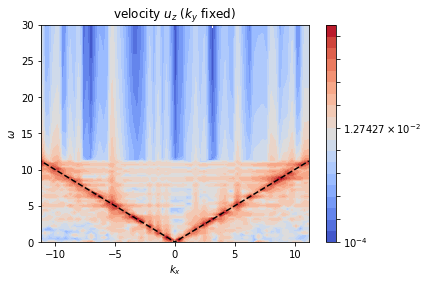

In [223]:
from matplotlib.colors import LogNorm

n_mode_y = 40

lvls = np.logspace(-4, 0, 20)
plt.contourf(KX[:, :, n_mode_y], W[:, :, n_mode_y], uz_fft_plot[:, :, n_mode_y]/uz_fft_plot[:, :, n_mode_y].max(), cmap = 'coolwarm', norm = LogNorm(), levels=lvls)

plt.ylim((0., 30.))
#plt.xlim((-5., 5.))

om_shear = disp.omegaS_xy(kx, 1., 1.)

plt.plot(ky, om_shear, 'k--')
plt.plot(-ky, om_shear, 'k--')

plt.xlabel('$k_x$')
plt.ylabel('$\omega$')
plt.title('velocity $u_z$ ($k_y$ fixed)')

plt.colorbar()

# 3. Results (new)

## $\delta f/\mathrm{full}-f$, $N_\mathrm{el}=[16, 2, 2]$, $p=[2, 1, 1]$, $N_\mathrm{p}=128000/1280000$, $\Delta t=0.05$, $n_\mathrm{quad-el}=[3, 2, 2]$, $n_\mathrm{quad-pr}=[6, 6, 6]$, cartesian

In [2]:
# import parameters and output data
import simulations.simulation_28042020_2.parameters_28042020_2 as pa
import simulations.simulation_28042020_2.equilibrium_PIC as eq_PIC
import simulations.simulation_28042020_2.equilibrium_MHD as eq_MHD

params = pa.parameters()


file_delta = h5py.File('simulations/simulation_28042020_1/results_simulation_28042020_1.hdf5', 'r')
file       = h5py.File('simulations/simulation_28042020_2/results_simulation_28042020_2.hdf5', 'r')

In [3]:
from scipy import integrate

# load data
Lx = params.params_map[0]
Ly = params.params_map[1]
Lz = params.params_map[2]

en_U   = file['energies/bulk_kinetic'][:]
en_B   = file['energies/magnetic'][:]
en_H   = file['energies/energetic_deltaf'][:]
en_p   = file['energies/bulk_internal'][:]

en_U_delta = file_delta['energies/bulk_kinetic'][:]
en_B_delta = file_delta['energies/magnetic'][:]
en_H_delta = file_delta['energies/energetic_deltaf'][:]
en_p_delta = file_delta['energies/bulk_internal'][:]

en_B0  = integrate.nquad(eq_MHD.bx_eq, [[0., Lx], [0., Ly], [0., Lz]])[0]/2
en_H0  = eq_PIC.eh_eq(params.kind_map, params.params_map)

tn     = file['time'][:]
en_tot = en_U + en_B + en_H + en_B0 + en_H0
en_tot_delta = en_U_delta + en_B_delta + en_H_delta + en_B0 + en_H0

#particles = file['particles']
fh_xi1_vx = file['distribution_function/xi1_vx'][:]
fh_xi1_vx_delta = file_delta['distribution_function/xi1_vx'][:]

#b1 = file['magnetic_field/1_component'][:]
#b2 = file['magnetic_field/2_component'][:]
#b3 = file['magnetic_field/3_component'][:]

# solve dispersion relation
w, counter = disp.solveDispersionFullOrbit(k=0.75, pol=+1, wch=+1, vA=1., vth=1., v0=2.5, nuh=0.05, Ah=1., Zh=1., AMHD=1., initial_guess=1. + 0j, tol=1e-10, max_it=100)
wi = np.imag(w)
wr = np.real(w)

# resonant velocity
vR = (wr + 1.)/0.75

In [6]:
en_B_delta[3600]

0.016123756752790427

Text(0,0.5,'y')

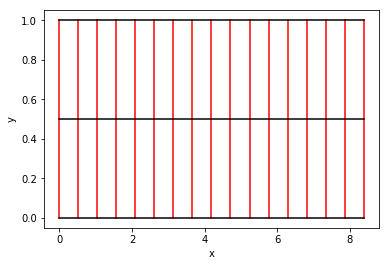

In [5]:
# plot grid
el_b = [np.linspace(0., 1., Nel + 1) for Nel in params.Nel]

xx = np.empty((el_b[0].size, el_b[1].size, el_b[2].size), dtype=float, order='F')
yy = np.empty((el_b[0].size, el_b[1].size, el_b[2].size), dtype=float, order='F')
zz = np.empty((el_b[0].size, el_b[1].size, el_b[2].size), dtype=float, order='F')

mapping.kernel_eva([el_b[0].size, el_b[1].size, el_b[2].size], el_b[0], el_b[1], el_b[2], xx, 1, params.kind_map, params.params_map)
mapping.kernel_eva([el_b[0].size, el_b[1].size, el_b[2].size], el_b[0], el_b[1], el_b[2], yy, 2, params.kind_map, params.params_map)
mapping.kernel_eva([el_b[0].size, el_b[1].size, el_b[2].size], el_b[0], el_b[1], el_b[2], zz, 3, params.kind_map, params.params_map)

# plot grid
for i in range(len(el_b[0])):
    plt.plot(xx[i, :, 0], yy[i, :, 0], 'r')
    
for i in range(len(el_b[1])):
    plt.plot(xx[:, i, 0], yy[:, i, 0], 'k')
    
plt.xlabel('x')
plt.ylabel('y')

Text(0,0.5,'$|\\epsilon-\\epsilon_0|/\\epsilon_0}$')

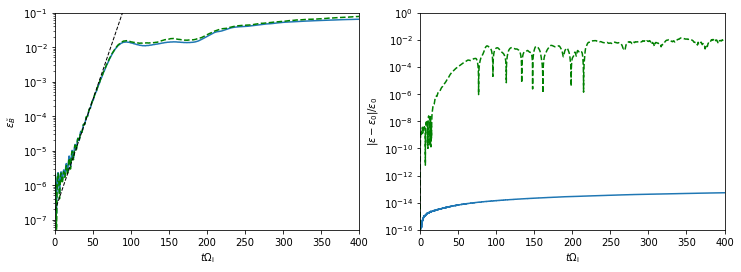

In [6]:
fig = plt.figure()
fig.set_figwidth(12)


plt.subplot(1, 2, 1)
plt.semilogy(tn, en_B)
plt.semilogy(tn, en_B_delta, 'g--')
#plt.semilogy(tn, en_U)
#plt.semilogy(tn, en_H + en_H0)
plt.ylim((5e-8, 1e-1))
plt.xlim((tn[0], 400.))
plt.semilogy(tn, 1.8e-7*np.exp(2*tn*wi), 'k--', linewidth=1)
plt.xlabel('$t\Omega_\mathrm{i}$')
plt.ylabel(r'$\epsilon_\tilde{B}$')

plt.subplot(1, 2, 2)
plt.semilogy(tn, np.abs(en_tot[0] - en_tot)/en_tot[0])
plt.semilogy(tn, np.abs(en_tot_delta[0] - en_tot_delta)/en_tot_delta[0], 'g--')
plt.ylim((1e-16, 1e0))
plt.xlim((tn[0], 400.))
plt.xlabel('$t\Omega_\mathrm{i}$')
plt.ylabel(r'$|\epsilon-\epsilon_0|/\epsilon_0}$')

In [7]:
# plot distribution function in parallel velocity direction (vx)
n_bins    = 32
bin_edges = np.linspace(0., 5., n_bins + 1)
dbin      = bin_edges[1] - bin_edges[0]
bins      = bin_edges[:-1] + dbin/2

fh_vx = np.sum(fh_xi1_vx, axis=1)/fh_xi1_vx.shape[1]
fh_vx_delta = np.sum(fh_xi1_vx_delta, axis=1)/fh_xi1_vx_delta.shape[1]

fh_vx = (fh_vx[:, 0::2] + fh_vx[:, 1::2])/2
fh_vx_delta = (fh_vx_delta[:, 0::2] + fh_vx_delta[:, 1::2])/2

/usr/local/lib/python3.5/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


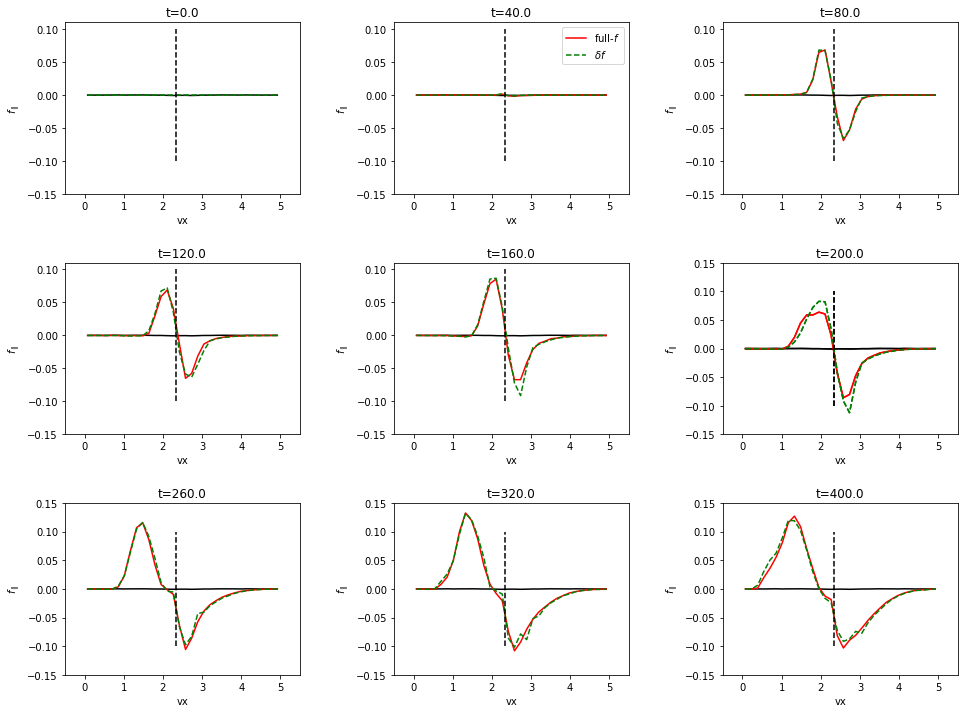

In [8]:
fh_vx_eq = lambda vx : 0.05*Lx*Ly*Lz/np.sqrt(np.pi)*params.vth*np.exp(-(vx - params.v0x)**2/params.vth**2)
vR = (wr + 1)/0.75


fig = plt.figure()
fig.set_figheight(12)
fig.set_figwidth(16)


plt.subplot(3, 3, 1)
plt.plot(bins, -fh_vx_eq(bins) + fh_vx[0],  'k')
plt.plot(bins, fh_vx_delta[0],  'g--')
plt.xlim((-0.5, 5.5))
plt.ylim((-0.15, 0.11))
plt.plot(np.ones(10)*vR, np.linspace(-0.1, 0.1, 10), 'k--')
plt.xlabel('vx')
plt.ylabel('$f_\parallel$')
plt.title('t=0.0')

plt.subplot(3, 3, 2)
plt.plot(bins, -fh_vx_eq(bins) + fh_vx[0],  'k')
plt.plot(bins, -fh_vx_eq(bins) + fh_vx[800], 'r', label='full-$f$')
plt.plot(bins, fh_vx_delta[800], 'g--', label='$\delta f$')
plt.legend()
plt.xlim((-0.5, 5.5))
plt.ylim((-0.15, 0.11))
plt.plot(np.ones(10)*vR, np.linspace(-0.1, 0.1, 10), 'k--')
plt.xlabel('vx')
plt.ylabel('$f_\parallel$')
plt.title('t=40.0')


plt.subplot(3, 3, 3)
plt.plot(bins, -fh_vx_eq(bins) + fh_vx[0],  'k')
plt.plot(bins, -fh_vx_eq(bins) + fh_vx[1600], 'r')
plt.plot(bins, fh_vx_delta[1600], 'g--')
plt.plot(np.ones(10)*vR, np.linspace(-0.1, 0.1, 10), 'k--')
plt.xlim((-0.5, 5.5))
plt.ylim((-0.15, 0.11))
plt.xlabel('vx')
plt.ylabel('$f_\parallel$')
plt.title('t=80.0')

plt.subplot(3, 3, 4)
plt.plot(bins, -fh_vx_eq(bins) + fh_vx[0],  'k')
plt.plot(bins, -fh_vx_eq(bins) + fh_vx[2400], 'r')
plt.plot(bins, fh_vx_delta[2400], 'g--')
plt.plot(np.ones(10)*vR, np.linspace(-0.1, 0.1, 10), 'k--')
plt.xlim((-0.5, 5.5))
plt.ylim((-0.15, 0.11))
plt.xlabel('vx')
plt.ylabel('$f_\parallel$')
plt.title('t=120.0')

plt.subplot(3, 3, 5)
plt.plot(bins, -fh_vx_eq(bins) + fh_vx[0],  'k')
plt.plot(bins, -fh_vx_eq(bins) + fh_vx[3200], 'r')
plt.plot(bins, fh_vx_delta[3200], 'g--')
plt.plot(np.ones(10)*vR, np.linspace(-0.1, 0.1, 10), 'k--')
plt.xlim((-0.5, 5.5))
plt.ylim((-0.15, 0.11))
plt.xlabel('vx')
plt.ylabel('$f_\parallel$')
plt.title('t=160.0')

plt.subplot(3, 3, 6)
plt.plot(bins, -fh_vx_eq(bins) + fh_vx[0],  'k')
plt.plot(bins, -fh_vx_eq(bins) + fh_vx[4000], 'r')
plt.plot(bins, fh_vx_delta[4000], 'g--')
plt.plot(np.ones(10)*vR, np.linspace(-0.1, 0.1, 10), 'k--')
plt.xlim((-0.5, 5.5))
plt.ylim((-0.15, 0.11))
plt.xlabel('vx')
plt.ylabel('$f_\parallel$')
plt.title('t=200.0')


plt.subplot(3, 3, 6)
plt.plot(bins, -fh_vx_eq(bins) + fh_vx[0],  'k')
plt.plot(bins, -fh_vx_eq(bins) + fh_vx[4000], 'r')
plt.plot(bins, fh_vx_delta[4000], 'g--')
plt.plot(np.ones(10)*vR, np.linspace(-0.1, 0.1, 10), 'k--')
plt.xlim((-0.5, 5.5))
plt.ylim((-0.15, 0.15))
plt.xlabel('vx')
plt.ylabel('$f_\parallel$')
plt.title('t=200.0')

plt.subplot(3, 3, 7)
plt.plot(bins, -fh_vx_eq(bins) + fh_vx[0],  'k')
plt.plot(bins, -fh_vx_eq(bins) + fh_vx[5200], 'r')
plt.plot(bins, fh_vx_delta[5200], 'g--')
plt.plot(np.ones(10)*vR, np.linspace(-0.1, 0.1, 10), 'k--')
plt.xlim((-0.5, 5.5))
plt.ylim((-0.15, 0.15))
plt.xlabel('vx')
plt.ylabel('$f_\parallel$')
plt.title('t=260.0')

plt.subplot(3, 3, 8)
plt.plot(bins, -fh_vx_eq(bins) + fh_vx[0],  'k')
plt.plot(bins, -fh_vx_eq(bins) + fh_vx[6400], 'r')
plt.plot(bins, fh_vx_delta[6400], 'g--')
plt.plot(np.ones(10)*vR, np.linspace(-0.1, 0.1, 10), 'k--')
plt.xlim((-0.5, 5.5))
plt.ylim((-0.15, 0.15))
plt.xlabel('vx')
plt.ylabel('$f_\parallel$')
plt.title('t=320.0')


plt.subplot(3, 3, 9)
plt.plot(bins, -fh_vx_eq(bins) + fh_vx[0],  'k')
plt.plot(bins, -fh_vx_eq(bins) + fh_vx[8000], 'r')
plt.plot(bins, fh_vx_delta[8000], 'g--')
plt.plot(np.ones(10)*vR, np.linspace(-0.1, 0.1, 10), 'k--')
plt.xlim((-0.5, 5.5))
plt.ylim((-0.15, 0.15))
plt.xlabel('vx')
plt.ylabel('$f_\parallel$')
plt.title('t=400.0')

plt.subplots_adjust(hspace=0.4, wspace=0.4)

In [9]:
# plot evolution of distribution function in x - vx space 
n_bins    = [fh_xi1_vx.shape[1], fh_xi1_vx.shape[2]]
bin_edges = [np.linspace(0., 1., n_bins[0] + 1), np.linspace(0., 5., n_bins[1] + 1)]
dbin      = [bin_edges[0][1] - bin_edges[0][0], bin_edges[1][1] - bin_edges[1][0]]
bins      = [bin_edges[0][:-1] + dbin[0]/2, bin_edges[1][:-1] + dbin[1]/2]

Text(0.5,1,'t=231.75')

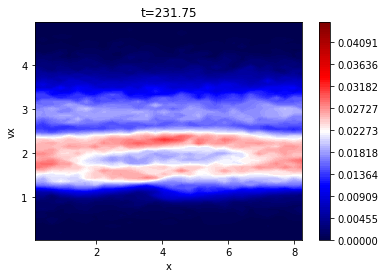

In [20]:
X, VX = np.meshgrid(bins[0]*Lx, bins[1], indexing='ij')
f_eq  = lambda x, vx : 0.05*Ly*Lz/np.sqrt(np.pi)*params.vth*np.exp(-(vx - params.v0x)**2/params.vth**2)
Nt    = fh_xi1_vx.shape[0] - 1

cont = plt.contourf(X, VX, fh_xi1_vx[4610]/Lx, np.linspace(0., 0.045, 100), cmap='seismic')
plt.colorbar()

plt.xlabel('x')
plt.ylabel('vx')
plt.title('t=231.75')

0
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
0


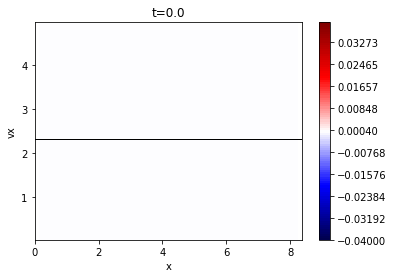

In [83]:
from matplotlib import animation

X, VX = np.meshgrid(bins[0]*Lx, bins[1], indexing='ij')
f_eq  = lambda x, vx : 0.05*Ly*Lz/np.sqrt(np.pi)*params.vth*np.exp(-(vx - params.v0x)**2/params.vth**2)
Nt    = fh_xi1_vx.shape[0] - 1

fig, ax = plt.subplots()

#cont = plt.contourf(X, VX, fh_xi1_vx[0]/Lx, np.linspace(0., 0.045, 100), cmap='seismic')
cont = plt.contourf(X, VX, fh_xi1_vx_delta[0]/Lx, np.linspace(-0.04, 0.04, 100), cmap='seismic')
plt.colorbar()
plt.plot(np.linspace(0., Lx, 10), np.ones(10)*vR, 'k--', linewidth=0.5)
plt.xlim((0., Lx))

# animation function
def animate(i):
    if i%100 == 0:
        print(i)
    global cont

    for c in cont.collections:
        c.remove()  # removes only the contours, leaves the rest intact
        
    #cont = plt.contourf(X, VX, fh_xi1_vx[i*5]/Lx, np.linspace(0., 0.045, 100), cmap='seismic')
    cont = plt.contourf(X, VX, fh_xi1_vx_delta[i*5]/Lx, np.linspace(-0.04, 0.04, 100), cmap='seismic')
    plt.plot(np.linspace(0., Lx, 10), np.ones(10)*vR, 'k--', linewidth=0.5)
    plt.xlim((0., Lx))
    
    plt.xlabel('x')
    plt.ylabel('vx')
    plt.title('t=' + str(tn[::5][i]))
    
    return cont

anim = animation.FuncAnimation(fig, animate, frames=int(Nt/5) + 1, repeat=False)
anim.save('animation_deltaf.mp4', writer=animation.FFMpegWriter())

## $\mathrm{full}-f$, $N_\mathrm{el}=[16, 2, 2]$, $p=[2, 1, 1]$, $N_\mathrm{p}=1024000$, $\Delta t=0.05$, $n_\mathrm{quad-el}=[3, 2, 2]$, $n_\mathrm{quad-pr}=[6, 6, 6]$, cartesian, with non-Hamiltonian terms

In [3]:
# import parameters and output data
import simulations.simulation_23042020_1.parameters_23042020_1 as pa
import simulations.simulation_23042020_1.equilibrium_PIC as eq_PIC
import simulations.simulation_23042020_1.equilibrium_MHD as eq_MHD

params = pa.parameters()

file = h5py.File('simulations/simulation_23042020_1/results_simulation_23042020_1.hdf5', 'r')

In [8]:
from scipy import integrate

# load data
Lx = params.params_map[0]
Ly = params.params_map[1]
Lz = params.params_map[2]

en_U   = file['energies/bulk_kinetic'][:]
en_B   = file['energies/magnetic'][:]
en_H   = file['energies/energetic_deltaf'][:]
en_p   = file['energies/bulk_internal'][:]

en_B0  = integrate.nquad(eq_MHD.bx_eq, [[0., Lx], [0., Ly], [0., Lz]])[0]/2
en_H0  = eq_PIC.eh_eq(params.kind_map, params.params_map)

tn     = file['time'][:]
en_tot = en_U + en_B + en_H + en_B0 + en_H0

pressure = file['pressure'][:]

# solve dispersion relation
w, counter = disp.solveDispersionFullOrbit(k=0.75, pol=+1, wch=+1, vA=1., vth=1., v0=2.5, nuh=0.05, Ah=1., Zh=1., AMHD=1., initial_guess=1. + 0j, tol=1e-10, max_it=100)
wi = np.imag(w)
wr = np.real(w)

Text(0,0.5,'$|\\epsilon-\\epsilon_0|/\\epsilon_0}$')

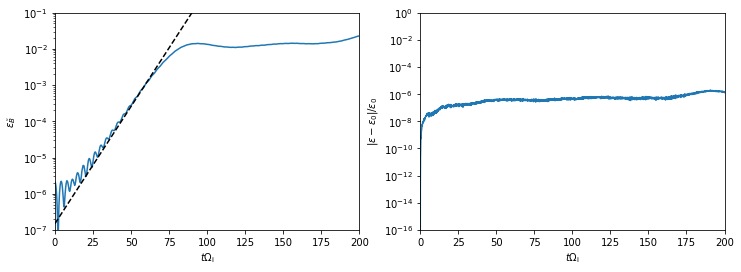

In [9]:
fig = plt.figure()
fig.set_figwidth(12)


plt.subplot(1, 2, 1)
plt.semilogy(tn, en_B)
plt.ylim((1e-7, 1e-1))
plt.xlim((tn[0], 200.))
plt.semilogy(tn, 1.5e-7*np.exp(2*tn*wi), 'k--')
plt.xlabel('$t\Omega_\mathrm{i}$')
plt.ylabel(r'$\epsilon_\tilde{B}$')

plt.subplot(1, 2, 2)
plt.semilogy(tn, np.abs(en_tot[0] - en_tot)/en_tot[0])
plt.ylim((1e-16, 1e0))
plt.xlim((tn[0], 200.))
plt.xlabel('$t\Omega_\mathrm{i}$')
plt.ylabel(r'$|\epsilon-\epsilon_0|/\epsilon_0}$')

## $\mathrm{full}-f$, $N_\mathrm{el}=[16, 16, 2]$, $p=[2, 2, 1]$, $N_\mathrm{p}=8192000$, $\Delta t=0.05$, $n_\mathrm{quad-el}=[6, 6, 6]$, $n_\mathrm{quad-pr}=[6, 6, 6]$, colella

In [53]:
# import parameters and output data
import simulations.simulation_25042020_1.parameters_25042020_1 as pa
import simulations.simulation_25042020_1.equilibrium_PIC as eq_PIC
import simulations.simulation_25042020_1.equilibrium_MHD as eq_MHD

params = pa.parameters()

file = h5py.File('simulations/simulation_25042020_1/results_simulation_25042020_1.hdf5', 'r')

In [54]:
from scipy import integrate

# load data
Lx = params.params_map[0]
Ly = params.params_map[1]
Lz = params.params_map[3]

en_U   = file['energies/bulk_kinetic'][:]
en_B   = file['energies/magnetic'][:]
en_H   = file['energies/energetic_deltaf'][:]
en_p   = file['energies/bulk_internal'][:]

en_B0  = integrate.nquad(eq_MHD.bx_eq, [[0., Lx], [0., Ly], [0., Lz]])[0]/2
en_H0  = eq_PIC.eh_eq(params.kind_map, params.params_map)

tn     = file['time'][:]
en_tot = en_U + en_B + en_H + en_B0 + en_H0

# solve dispersion relation
w, counter = disp.solveDispersionFullOrbit(k=0.75, pol=+1, wch=+1, vA=1., vth=1., v0=2.5, nuh=0.05, Ah=1., Zh=1., AMHD=1., initial_guess=1. + 0j, tol=1e-10, max_it=100)
wi = np.imag(w)
wr = np.real(w)

# resonant velocity
vR = (wr + 1.)/0.75

Text(0,0.5,'y')

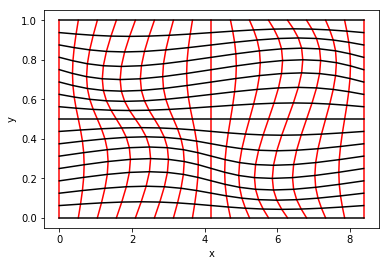

In [59]:
# plot grid
el_b = [np.linspace(0., 1., Nel + 1) for Nel in params.Nel]

xx = np.empty((el_b[0].size, el_b[1].size, el_b[2].size), dtype=float, order='F')
yy = np.empty((el_b[0].size, el_b[1].size, el_b[2].size), dtype=float, order='F')
zz = np.empty((el_b[0].size, el_b[1].size, el_b[2].size), dtype=float, order='F')

mapping.kernel_eva([el_b[0].size, el_b[1].size, el_b[2].size], el_b[0], el_b[1], el_b[2], xx, 1, params.kind_map, params.params_map)
mapping.kernel_eva([el_b[0].size, el_b[1].size, el_b[2].size], el_b[0], el_b[1], el_b[2], yy, 2, params.kind_map, params.params_map)
mapping.kernel_eva([el_b[0].size, el_b[1].size, el_b[2].size], el_b[0], el_b[1], el_b[2], zz, 3, params.kind_map, params.params_map)

# plot grid
for i in range(len(el_b[0])):
    plt.plot(xx[i, :, 0], yy[i, :, 0], 'r')
    
for i in range(len(el_b[1])):
    plt.plot(xx[:, i, 0], yy[:, i, 0], 'k')
    
plt.xlabel('x')
plt.ylabel('y')

Text(0,0.5,'$|\\epsilon-\\epsilon_0|/\\epsilon_0}$')

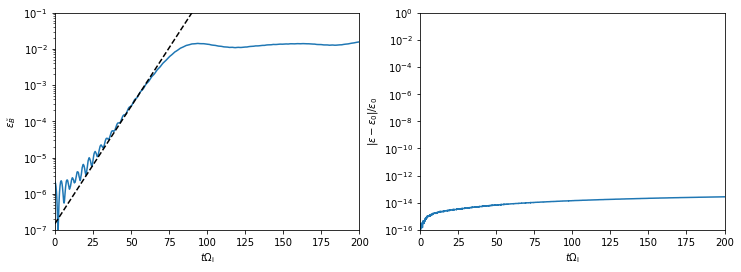

In [55]:
fig = plt.figure()
fig.set_figwidth(12)


plt.subplot(1, 2, 1)
plt.semilogy(tn, en_B)
plt.ylim((1e-7, 1e-1))
plt.xlim((tn[0], 200.))
plt.semilogy(tn, 1.5e-7*np.exp(2*tn*wi), 'k--')
plt.xlabel('$t\Omega_\mathrm{i}$')
plt.ylabel(r'$\epsilon_\tilde{B}$')

plt.subplot(1, 2, 2)
plt.semilogy(tn, np.abs(en_tot[0] - en_tot)/en_tot[0])
plt.ylim((1e-16, 1e0))
plt.xlim((tn[0], 200.))
plt.xlabel('$t\Omega_\mathrm{i}$')
plt.ylabel(r'$|\epsilon-\epsilon_0|/\epsilon_0}$')

In [56]:
particles_ini = file['particles'][0]
particles_end = file['restart/particles'][0]

In [57]:
# plot initial and final distribution function in parallel velocity direction
v0x = params.v0x
Np  = params.Np

n_bins_vx    = 50
bin_edges_vx = np.linspace(v0x - 3., v0x + 3., n_bins_vx + 1)
dbin_vx      = bin_edges_vx[1] - bin_edges_vx[0]
bins_vx      = bin_edges_vx[:-1] + dbin_vx/2

fh_vx_ini    = np.zeros(n_bins_vx, dtype=float)
fh_vx_end    = np.zeros(n_bins_vx, dtype=float)

binning_vx_ini = np.digitize(particles_ini[:, 3], bin_edges_vx) - 1
binning_vx_end = np.digitize(particles_end[:, 3], bin_edges_vx) - 1

for i in range(n_bins_vx):
    fh_vx_ini[i] = sum(particles_ini[binning_vx_ini == i, 6])/(Np*dbin_vx) 
    fh_vx_end[i] = sum(particles_end[binning_vx_end == i, 6])/(Np*dbin_vx) 

Text(0,0.5,'$f_\\parallel$')

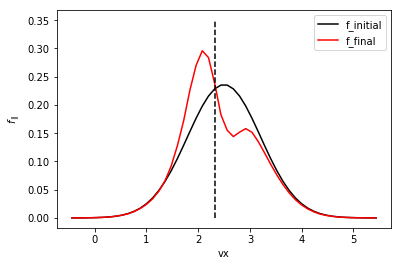

In [58]:
plt.plot(bins_vx, fh_vx_ini, 'k', label='f_initial')
plt.plot(bins_vx, fh_vx_end, 'r', label='f_final')

plt.plot(np.ones(10)*vR, np.linspace(0., 0.35, 10), 'k--')
plt.legend()

plt.xlabel('vx')
plt.ylabel('$f_\parallel$')

## $\delta f$, $N_\mathrm{el}=[32, 2, 2]$, $p=[3, 1, 1]$, $N_\mathrm{p}=512000$, $\Delta t=0.04$, $n_\mathrm{quad-el}=[6, 6, 6]$, $n_\mathrm{quad-pr}=[6, 6, 6]$, cartesian, sobol antithetic

In [2]:
# import parameters and output data
import simulations.simulation_06052020_1.parameters_06052020_1 as pa
import simulations.simulation_06052020_1.equilibrium_PIC as eq_PIC
import simulations.simulation_06052020_1.equilibrium_MHD as eq_MHD

params = pa.parameters()

file = h5py.File('simulations/simulation_06052020_1/results_simulation_06052020_1.hdf5', 'r')

In [3]:
from scipy import integrate

# load data
Lx = params.params_map[0]
Ly = params.params_map[1]
Lz = params.params_map[2]

en_U   = file['energies/bulk_kinetic'][:]
en_B   = file['energies/magnetic'][:]
en_H   = file['energies/energetic_deltaf'][:]
en_p   = file['energies/bulk_internal'][:]

en_B0  = integrate.nquad(eq_MHD.bx_eq, [[0., Lx], [0., Ly], [0., Lz]])[0]/2
en_H0  = eq_PIC.eh_eq(params.kind_map, params.params_map)

tn     = file['time'][:]
en_tot = en_U + en_B + en_H + en_B0 + en_H0

#particles = file['particles']
fh_xi1_vx = file['distribution_function/xi1_vx'][:]

#b1 = file['magnetic_field/1_component'][:]
#b2 = file['magnetic_field/2_component'][:]
#b3 = file['magnetic_field/3_component'][:]

# solve dispersion relation
w, counter = disp.solveDispersionFullOrbit(k=0.75, pol=+1, wch=+1, vA=1., vth=1., v0=2.5, nuh=0.05, Ah=1., Zh=1., AMHD=1., initial_guess=1. + 0j, tol=1e-10, max_it=100)
wi = np.imag(w)
wr = np.real(w)

# resonant velocity
vR = (wr + 1.)/0.75

Text(0,0.5,'y')

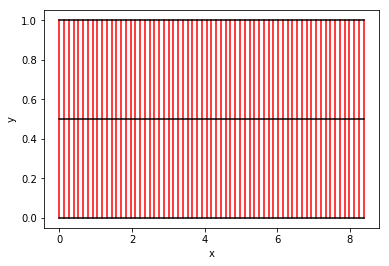

In [4]:
# plot grid
el_b = [np.linspace(0., 1., Nel + 1) for Nel in params.Nel]

xx = np.empty((el_b[0].size, el_b[1].size, el_b[2].size), dtype=float, order='F')
yy = np.empty((el_b[0].size, el_b[1].size, el_b[2].size), dtype=float, order='F')
zz = np.empty((el_b[0].size, el_b[1].size, el_b[2].size), dtype=float, order='F')

mapping.kernel_eva([el_b[0].size, el_b[1].size, el_b[2].size], el_b[0], el_b[1], el_b[2], xx, 1, params.kind_map, params.params_map)
mapping.kernel_eva([el_b[0].size, el_b[1].size, el_b[2].size], el_b[0], el_b[1], el_b[2], yy, 2, params.kind_map, params.params_map)
mapping.kernel_eva([el_b[0].size, el_b[1].size, el_b[2].size], el_b[0], el_b[1], el_b[2], zz, 3, params.kind_map, params.params_map)

# plot grid
for i in range(len(el_b[0])):
    plt.plot(xx[i, :, 0], yy[i, :, 0], 'r')
    
for i in range(len(el_b[1])):
    plt.plot(xx[:, i, 0], yy[:, i, 0], 'k')
    
plt.xlabel('x')
plt.ylabel('y')

Text(0,0.5,'$|\\epsilon-\\epsilon_0|/\\epsilon_0}$')

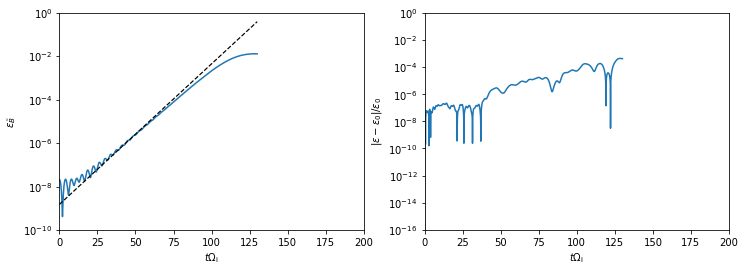

In [5]:
fig = plt.figure()
fig.set_figwidth(12)


plt.subplot(1, 2, 1)
plt.semilogy(tn, en_B)
#plt.semilogy(tn, en_U)
#plt.semilogy(tn, en_H + en_H0)
plt.ylim((1e-10, 1e0))
plt.xlim((tn[0], 200.))
plt.semilogy(tn, 1.5e-9*np.exp(2*tn*wi), 'k--', linewidth=1.2)
plt.xlabel('$t\Omega_\mathrm{i}$')
plt.ylabel(r'$\epsilon_\tilde{B}$')

plt.subplot(1, 2, 2)
plt.semilogy(tn, np.abs(en_tot[0] - en_tot)/en_tot[0])
plt.ylim((1e-16, 1e0))
plt.xlim((tn[0], 200.))
plt.xlabel('$t\Omega_\mathrm{i}$')
plt.ylabel(r'$|\epsilon-\epsilon_0|/\epsilon_0}$')

## $\mathrm{full}-f$, $N_\mathrm{el}=[8, 2, 2]$, $p=[2, 1, 1]$, $N_\mathrm{p}=512000$, $\Delta t=0.05$, $n_\mathrm{quad-el}=[6, 6, 6]$, $n_\mathrm{quad-pr}=[6, 6, 6]$, cartesian, sobol antithetic

In [42]:
# import parameters and output data
import simulations.simulation_29042020_1.parameters_29042020_1 as pa
import simulations.simulation_29042020_1.equilibrium_PIC as eq_PIC
import simulations.simulation_29042020_1.equilibrium_MHD as eq_MHD

params = pa.parameters()

file = h5py.File('simulations/simulation_29042020_1/results_simulation_29042020_1.hdf5', 'r')

In [43]:
from scipy import integrate

# load data
Lx = params.params_map[0]
Ly = params.params_map[1]
Lz = params.params_map[2]

en_U   = file['energies/bulk_kinetic'][:]
en_B   = file['energies/magnetic'][:]
en_H   = file['energies/energetic_deltaf'][:]
en_p   = file['energies/bulk_internal'][:]

en_B0  = integrate.nquad(eq_MHD.bx_eq, [[0., Lx], [0., Ly], [0., Lz]])[0]/2
en_H0  = eq_PIC.eh_eq(params.kind_map, params.params_map)

tn     = file['time'][:]
en_tot = en_U + en_B + en_H + en_B0 + en_H0

#particles = file['particles']
fh_xi1_vx = file['distribution_function/xi1_vx'][:]

#b1 = file['magnetic_field/1_component'][:]
#b2 = file['magnetic_field/2_component'][:]
#b3 = file['magnetic_field/3_component'][:]

# solve dispersion relation
w, counter = disp.solveDispersionFullOrbit(k=0.75, pol=+1, wch=+1, vA=1., vth=1., v0=2.5, nuh=0.05, Ah=1., Zh=1., AMHD=1., initial_guess=1. + 0j, tol=1e-10, max_it=100)
wi = np.imag(w)
wr = np.real(w)

# resonant velocity
vR = (wr + 1.)/0.75

Text(0,0.5,'y')

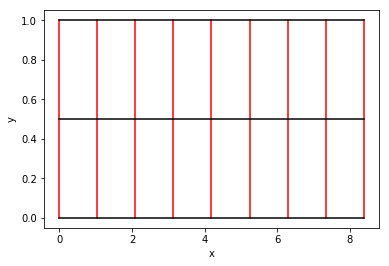

In [44]:
# plot grid
el_b = [np.linspace(0., 1., Nel + 1) for Nel in params.Nel]

xx = np.empty((el_b[0].size, el_b[1].size, el_b[2].size), dtype=float, order='F')
yy = np.empty((el_b[0].size, el_b[1].size, el_b[2].size), dtype=float, order='F')
zz = np.empty((el_b[0].size, el_b[1].size, el_b[2].size), dtype=float, order='F')

mapping.kernel_eva([el_b[0].size, el_b[1].size, el_b[2].size], el_b[0], el_b[1], el_b[2], xx, 1, params.kind_map, params.params_map)
mapping.kernel_eva([el_b[0].size, el_b[1].size, el_b[2].size], el_b[0], el_b[1], el_b[2], yy, 2, params.kind_map, params.params_map)
mapping.kernel_eva([el_b[0].size, el_b[1].size, el_b[2].size], el_b[0], el_b[1], el_b[2], zz, 3, params.kind_map, params.params_map)

# plot grid
for i in range(len(el_b[0])):
    plt.plot(xx[i, :, 0], yy[i, :, 0], 'r')
    
for i in range(len(el_b[1])):
    plt.plot(xx[:, i, 0], yy[:, i, 0], 'k')
    
plt.xlabel('x')
plt.ylabel('y')

Text(0,0.5,'$|\\epsilon-\\epsilon_0|/\\epsilon_0}$')

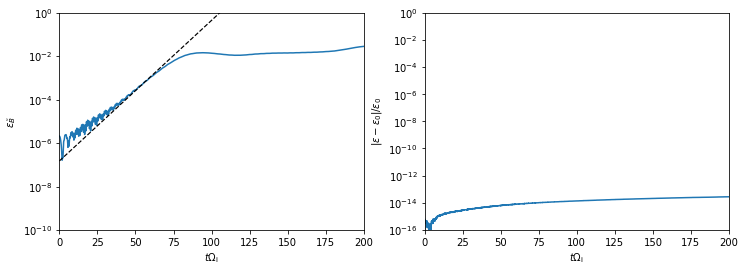

In [46]:
fig = plt.figure()
fig.set_figwidth(12)


plt.subplot(1, 2, 1)
plt.semilogy(tn, en_B)
#plt.semilogy(tn, en_U)
#plt.semilogy(tn, en_H + en_H0)
plt.ylim((1e-10, 1e0))
plt.xlim((tn[0], 200.))
plt.semilogy(tn, 1.5e-7*np.exp(2*tn*wi), 'k--', linewidth=1.2)
plt.xlabel('$t\Omega_\mathrm{i}$')
plt.ylabel(r'$\epsilon_\tilde{B}$')

plt.subplot(1, 2, 2)
plt.semilogy(tn, np.abs(en_tot[0] - en_tot)/en_tot[0])
plt.ylim((1e-16, 1e0))
plt.xlim((tn[0], 200.))
plt.xlabel('$t\Omega_\mathrm{i}$')
plt.ylabel(r'$|\epsilon-\epsilon_0|/\epsilon_0}$')

## $\delta f$, $N_\mathrm{el}=[32, 2, 2]$, $p=[3, 1, 1]$, $N_\mathrm{p}=512000$, $\Delta t=0.05$, $n_\mathrm{quad-el}=[6, 6, 6]$, $n_\mathrm{quad-pr}=[6, 6, 6]$, cartesian, pseudo-random, $k=1.2, 0.8, 1.0, 1.4, 1.6, 1.8, 2.0$

In [21]:
# import parameters and output data
import simulations.simulation_07052020_1.parameters_07052020_1 as pa
import simulations.simulation_07052020_1.equilibrium_PIC as eq_PIC
import simulations.simulation_07052020_1.equilibrium_MHD as eq_MHD

params = pa.parameters()

file1 = h5py.File('simulations/simulation_07052020_1/results_simulation_07052020_1.hdf5', 'r')
file2 = h5py.File('simulations/simulation_07052020_2/results_simulation_07052020_2.hdf5', 'r')
file3 = h5py.File('simulations/simulation_07052020_3/results_simulation_07052020_3.hdf5', 'r')
file4 = h5py.File('simulations/simulation_07052020_4/results_simulation_07052020_4.hdf5', 'r')
file5 = h5py.File('simulations/simulation_11052020_1/results_simulation_11052020_1.hdf5', 'r')
file6 = h5py.File('simulations/simulation_11052020_2/results_simulation_11052020_2.hdf5', 'r')
file7 = h5py.File('simulations/simulation_11052020_3/results_simulation_11052020_3.hdf5', 'r')

In [22]:
from scipy import integrate

# load data
Lx = params.params_map[0]
Ly = params.params_map[1]
Lz = params.params_map[2]

en_U1   = file1['energies/bulk_kinetic'][:]
en_B1   = file1['energies/magnetic'][:]
en_H1   = file1['energies/energetic_deltaf'][:]
en_p1   = file1['energies/bulk_internal'][:]

en_U2   = file2['energies/bulk_kinetic'][:]
en_B2   = file2['energies/magnetic'][:]
en_H2   = file2['energies/energetic_deltaf'][:]
en_p2   = file2['energies/bulk_internal'][:]

en_U3   = file3['energies/bulk_kinetic'][:]
en_B3   = file3['energies/magnetic'][:]
en_H3   = file3['energies/energetic_deltaf'][:]
en_p3   = file3['energies/bulk_internal'][:]

en_U4   = file4['energies/bulk_kinetic'][:]
en_B4   = file4['energies/magnetic'][:]
en_H4   = file4['energies/energetic_deltaf'][:]
en_p4   = file4['energies/bulk_internal'][:]

en_U5   = file5['energies/bulk_kinetic'][:]
en_B5   = file5['energies/magnetic'][:]
en_H5   = file5['energies/energetic_deltaf'][:]
en_p5   = file5['energies/bulk_internal'][:]

en_U6   = file6['energies/bulk_kinetic'][:]
en_B6   = file6['energies/magnetic'][:]
en_H6   = file6['energies/energetic_deltaf'][:]
en_p6   = file6['energies/bulk_internal'][:]

en_U7   = file7['energies/bulk_kinetic'][:]
en_B7   = file7['energies/magnetic'][:]
en_H7   = file7['energies/energetic_deltaf'][:]
en_p7   = file7['energies/bulk_internal'][:]

en_B0  = integrate.nquad(eq_MHD.bx_eq, [[0., Lx], [0., Ly], [0., Lz]])[0]/2
en_H0  = eq_PIC.eh_eq(params.kind_map, params.params_map)

tn1     = file1['time'][:]
tn2     = file2['time'][:]
tn3     = file3['time'][:]
tn4     = file4['time'][:]
tn5     = file5['time'][:]
tn6     = file6['time'][:]
tn7     = file7['time'][:]

en_tot1 = en_U1 + en_B1 + en_H1 + en_B0 + en_H0
en_tot2 = en_U2 + en_B2 + en_H2 + en_B0 + en_H0
en_tot3 = en_U3 + en_B3 + en_H3 + en_B0 + en_H0
en_tot4 = en_U4 + en_B4 + en_H4 + en_B0 + en_H0
en_tot5 = en_U5 + en_B5 + en_H5 + en_B0 + en_H0
en_tot6 = en_U6 + en_B6 + en_H6 + en_B0 + en_H0
en_tot7 = en_U7 + en_B7 + en_H7 + en_B0 + en_H0


# solve dispersion relation
w = np.zeros(7, dtype=complex)
ks = np.array([1.2, 0.8, 1.0, 1.4, 1.6, 1.8, 2.0])

for i in range(7):
    w[i], counter = disp.solveDispersionFullOrbit(k=ks[i], pol=+1, wch=+1, vA=1., vth=1., v0=2.0, nuh=0.06, Ah=1., Zh=1., AMHD=1., initial_guess=ks[i] + 0j, tol=1e-10, max_it=100)

Text(0,0.5,'$|\\epsilon-\\epsilon_0|/\\epsilon_0}$')

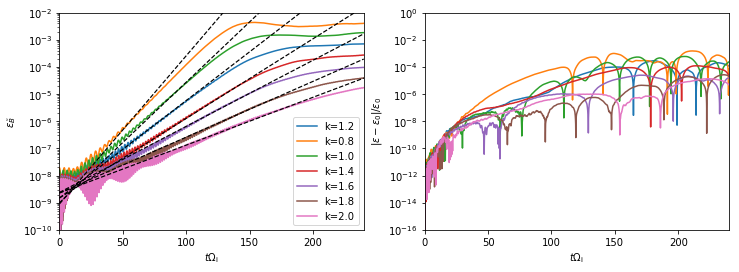

In [26]:
fig = plt.figure()
fig.set_figwidth(12)


plt.subplot(1, 2, 1)
plt.semilogy(tn1, en_B1, label='k=1.2')
plt.semilogy(tn2, en_B2, label='k=0.8')
plt.semilogy(tn3, en_B3, label='k=1.0')
plt.semilogy(tn4, en_B4, label='k=1.4')
plt.semilogy(tn5, en_B5, label='k=1.6')
plt.semilogy(tn6, en_B6, label='k=1.8')
plt.semilogy(tn7, en_B7, label='k=2.0')
plt.ylim((1e-10, 1e-2))
plt.xlim((tn1[0], 240.))
plt.semilogy(tn1, 1.5e-9*np.exp(2*tn1*np.imag(w[0])), 'k--', linewidth=1.2)
plt.semilogy(tn2, 9.0e-10*np.exp(2*tn2*np.imag(w[1])), 'k--', linewidth=1.2)
plt.semilogy(tn3, 1.0e-9*np.exp(2*tn3*np.imag(w[2])), 'k--', linewidth=1.2)
plt.semilogy(tn4, 1.5e-9*np.exp(2*tn4*np.imag(w[3])), 'k--', linewidth=1.2)
plt.semilogy(tn5, 2.4e-9*np.exp(2*tn5*np.imag(w[4])), 'k--', linewidth=1.2)
plt.semilogy(tn6, 2.3e-9*np.exp(2*tn6*np.imag(w[5])), 'k--', linewidth=1.2)
plt.semilogy(tn7, 2.3e-9*np.exp(2*tn7*np.imag(w[6])), 'k--', linewidth=1.2)
plt.xlabel('$t\Omega_\mathrm{i}$')
plt.ylabel(r'$\epsilon_\tilde{B}$')
plt.legend()

plt.subplot(1, 2, 2)
plt.semilogy(tn1, np.abs(en_tot1[0] - en_tot1)/en_tot1[0])
plt.semilogy(tn2, np.abs(en_tot2[0] - en_tot2)/en_tot2[0])
plt.semilogy(tn3, np.abs(en_tot3[0] - en_tot3)/en_tot3[0])
plt.semilogy(tn4, np.abs(en_tot4[0] - en_tot4)/en_tot4[0])
plt.semilogy(tn5, np.abs(en_tot5[0] - en_tot5)/en_tot5[0])
plt.semilogy(tn6, np.abs(en_tot6[0] - en_tot6)/en_tot6[0])
plt.semilogy(tn7, np.abs(en_tot7[0] - en_tot7)/en_tot7[0])
plt.ylim((1e-16, 1e0))
plt.xlim((tn1[0], 240.))
plt.xlabel('$t\Omega_\mathrm{i}$')
plt.ylabel(r'$|\epsilon-\epsilon_0|/\epsilon_0}$')

## $\delta f$, $N_\mathrm{el}=[16, 16, 2]$, $p=[2, 2, 1]$, $N_\mathrm{p}=1024000$, $\Delta t=0.05$, $n_\mathrm{quad-el}=[6, 6, 6]$, $n_\mathrm{quad-pr}=[6, 6, 6]$, colella, pseudo-random, $k=1.2$

In [2]:
# import parameters and output data
import simulations.simulation_18052020_1.parameters_18052020_1 as pa
import simulations.simulation_18052020_1.equilibrium_PIC as eq_PIC
import simulations.simulation_18052020_1.equilibrium_MHD as eq_MHD

params = pa.parameters()

file = h5py.File('simulations/simulation_18052020_1/results_simulation_18052020_1.hdf5', 'r')

In [3]:
from scipy import integrate

# load data
Lx = params.params_map[0]
Ly = params.params_map[1]
Lz = params.params_map[3]

en_U   = file['energies/bulk_kinetic'][:]
en_B   = file['energies/magnetic'][:]
en_H   = file['energies/energetic_deltaf'][:]
en_p   = file['energies/bulk_internal'][:]

en_B0  = integrate.nquad(eq_MHD.bx_eq, [[0., Lx], [0., Ly], [0., Lz]])[0]/2
en_H0  = eq_PIC.eh_eq(params.kind_map, params.params_map)

tn     = file['time'][:]
en_tot = en_U + en_B + en_H + en_B0 + en_H0

#particles = file['particles']
#fh_xi1_vx = file['distribution_function/xi1_vx'][:]

#b1 = file['magnetic_field/1_component'][:]
#b2 = file['magnetic_field/2_component'][:]
#b3 = file['magnetic_field/3_component'][:]

# solve dispersion relation
w, counter = disp.solveDispersionFullOrbit(k=1.2, pol=+1, wch=+1, vA=1., vth=1., v0=2.0, nuh=0.06, Ah=1., Zh=1., AMHD=1., initial_guess=1.2 + 0j, tol=1e-10, max_it=100)
wi = np.imag(w)
wr = np.real(w)

# resonant velocity
vR = (wr + 1.)/1.2

Text(0, 0.5, 'y')

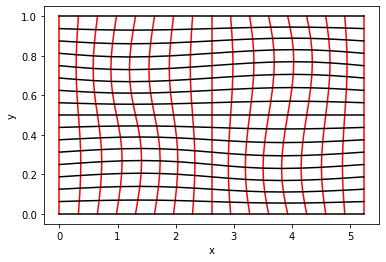

In [4]:
# plot grid
el_b = [np.linspace(0., 1., Nel + 1) for Nel in params.Nel]

xx = np.empty((el_b[0].size, el_b[1].size, el_b[2].size), dtype=float, order='F')
yy = np.empty((el_b[0].size, el_b[1].size, el_b[2].size), dtype=float, order='F')
zz = np.empty((el_b[0].size, el_b[1].size, el_b[2].size), dtype=float, order='F')

mapping.kernel_eva([el_b[0].size, el_b[1].size, el_b[2].size], el_b[0], el_b[1], el_b[2], xx, 1, params.kind_map, params.params_map)
mapping.kernel_eva([el_b[0].size, el_b[1].size, el_b[2].size], el_b[0], el_b[1], el_b[2], yy, 2, params.kind_map, params.params_map)
mapping.kernel_eva([el_b[0].size, el_b[1].size, el_b[2].size], el_b[0], el_b[1], el_b[2], zz, 3, params.kind_map, params.params_map)

# plot grid
for i in range(len(el_b[0])):
    plt.plot(xx[i, :, 0], yy[i, :, 0], 'r')
    
for i in range(len(el_b[1])):
    plt.plot(xx[:, i, 0], yy[:, i, 0], 'k')
    
plt.xlabel('x')
plt.ylabel('y')

Text(0, 0.5, '$|\\epsilon-\\epsilon_0|/\\epsilon_0}$')

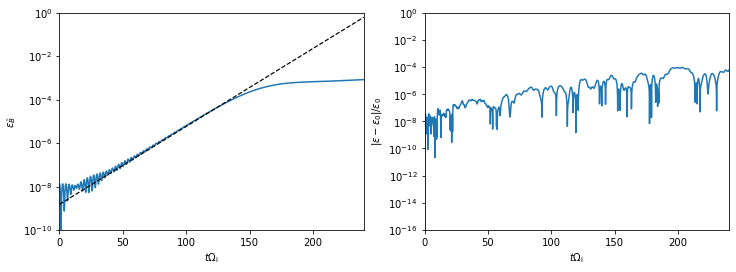

In [5]:
fig = plt.figure()
fig.set_figwidth(12)


plt.subplot(1, 2, 1)
plt.semilogy(tn, en_B)
#plt.semilogy(tn, en_U)
#plt.semilogy(tn, en_H + en_H0)
plt.ylim((1e-10, 1e0))
plt.xlim((tn[0], 240.))
plt.semilogy(tn, 1.5e-9*np.exp(2*tn*wi), 'k--', linewidth=1.2)
plt.xlabel('$t\Omega_\mathrm{i}$')
plt.ylabel(r'$\epsilon_\tilde{B}$')

plt.subplot(1, 2, 2)
plt.semilogy(tn, np.abs(en_tot[0] - en_tot)/en_tot[0])
plt.ylim((1e-16, 1e0))
plt.xlim((tn[0], 240.))
plt.xlabel('$t\Omega_\mathrm{i}$')
plt.ylabel(r'$|\epsilon-\epsilon_0|/\epsilon_0}$')

In [6]:
wi

0.04128434360378744